<a href="https://colab.research.google.com/github/daveandex/newGitTest/blob/master/German_Traffic_Sign_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## German Traffic Sign Classification 


In [0]:
# Importing Python libraries
import pickle
import numpy as np
import matplotlib.pyplot as plt
import random

import skimage.morphology as morp
from skimage.filters import rank
from sklearn.utils import shuffle

from pandas.io.parsers import read_csv
import os
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=FutureWarning)
    import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization

from sklearn.metrics import confusion_matrix
from skimage import color

%matplotlib inline


## The Dataset

The pickled data (You can get it [here](https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip) ) is a dictionary with 4 key-value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. 
- The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image.


In [2]:
!wget --output-document=traffic-signs-data.zip 'https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip'

!unzip traffic-signs-data.zip -d traffic-signs-data

--2018-12-25 10:28:25--  https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip
Resolving d17h27t6h515a5.cloudfront.net (d17h27t6h515a5.cloudfront.net)... 52.84.245.132, 52.84.245.127, 52.84.245.112, ...
Connecting to d17h27t6h515a5.cloudfront.net (d17h27t6h515a5.cloudfront.net)|52.84.245.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 123524425 (118M) [application/zip]
Saving to: ‘traffic-signs-data.zip’

traffic-signs-data. 100%[===================>] 117.80M  13.1MB/s    in 9.9s    

2018-12-25 10:28:36 (11.9 MB/s) - ‘traffic-signs-data.zip’ saved [123524425/123524425]

Archive:  traffic-signs-data.zip
  inflating: traffic-signs-data/test.p  
  inflating: traffic-signs-data/train.p  
  inflating: traffic-signs-data/valid.p  


In [5]:
# Code to mount google drive
#from google.colab import drive
#drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# New Section

** Let us load the data and extract the columns we are interested in ['features', 'labels'] **

In [0]:
def load_data(filename):
    """
    Opens and loads the datasets having a pickle data format. 
    
    Args:
        filename: name of the file (or the filepath)    

    Returns:
        X: the feature matrix
        y: class labels 
    """

    with open(filename, mode='rb') as f:
        data = pickle.load(f)
        
    X, y = data['features']/255.0, data['labels']
    
    return X, y


In [65]:
training = "./traffic-signs-data/train.p"
validation= "./traffic-signs-data/valid.p"
testing = "./traffic-signs-data/test.p"

X_train, y_train = load_data(training)
X_test, y_test = load_data(testing)
X_val, y_val = load_data(validation)

# Get the sign names
signs = read_csv("./signnames.csv").values[:, 1]

# Image size 
image_size = X_train[0].shape

# Number of training, validation, and test examples
n_train = X_train.shape[0]
n_val = X_val.shape[0]
n_test = X_test.shape[0]

# Number of unique traffic symbols
n_classes = len(np.unique(y_train))

print("Image size =", image_size)
print("Number of training examples: ", n_train)
print("Number of validation examples: ", n_val)
print("Number of testing examples: ", n_test)
print("Number of classes =", n_classes)



Image size = (32, 32, 3)
Number of training examples:  34799
Number of validation examples:  4410
Number of testing examples:  12630
Number of classes = 43


** Lets explore what the dataset looks like **
- visualizing 10 samples from each class

In [0]:
# Read the sign index to sign name mapper
#signs = read_csv('signnames.csv', delimiter=',').values[:, 1]


Speed limit (20km/h)


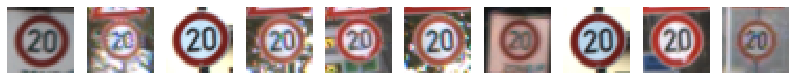

Speed limit (30km/h)


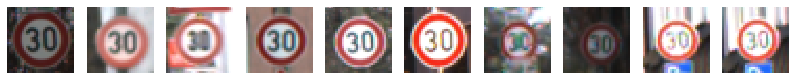

Speed limit (50km/h)


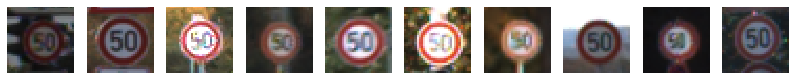

Speed limit (60km/h)


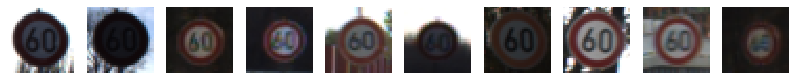

Speed limit (70km/h)


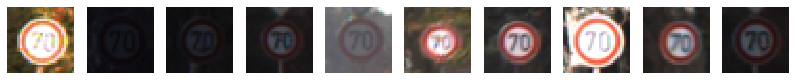

Speed limit (80km/h)


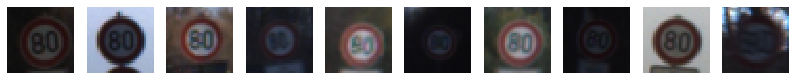

End of speed limit (80km/h)


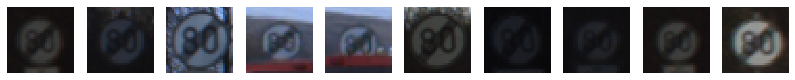

Speed limit (100km/h)


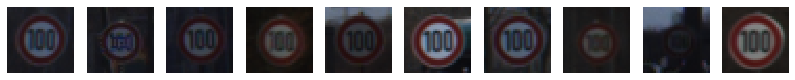

Speed limit (120km/h)


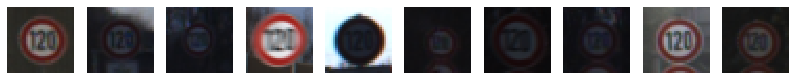

No passing


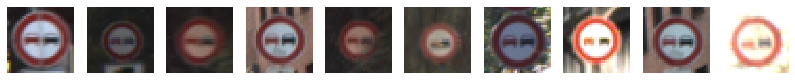

No passing for vehicles over 3.5 metric tons


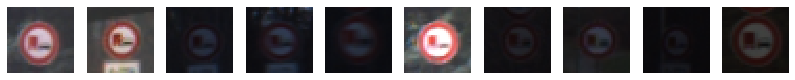

Right-of-way at the next intersection


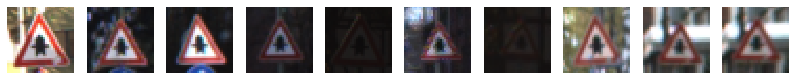

Priority road


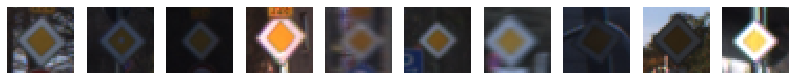

Yield


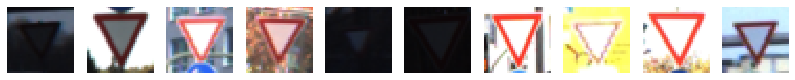

Stop


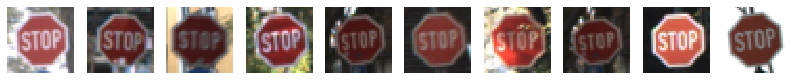

No vehicles


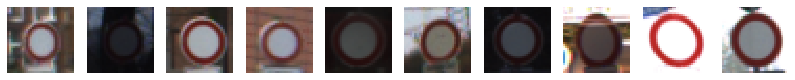

Vehicles over 3.5 metric tons prohibited


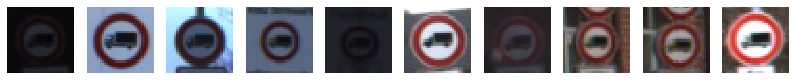

No entry


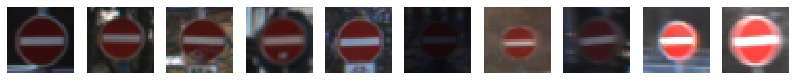

General caution


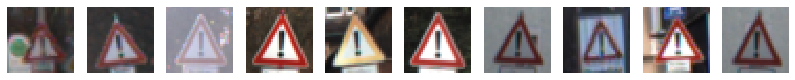

Dangerous curve to the left


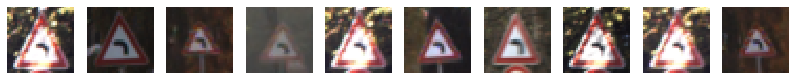

Dangerous curve to the right


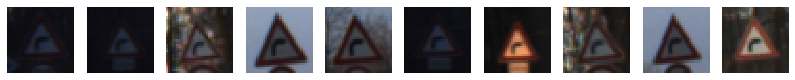

Double curve


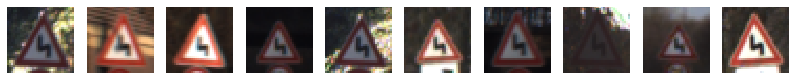

Bumpy road


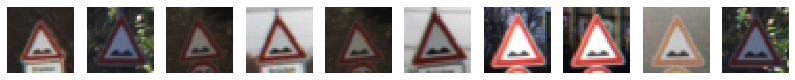

Slippery road


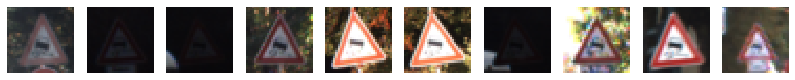

Road narrows on the right


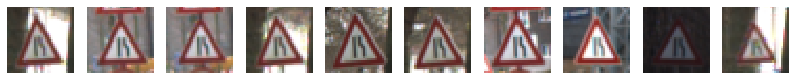

Road work


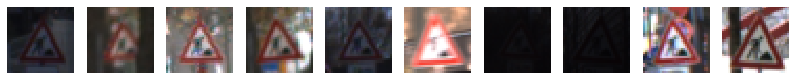

Traffic signals


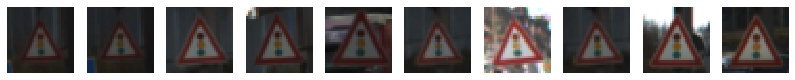

Pedestrians


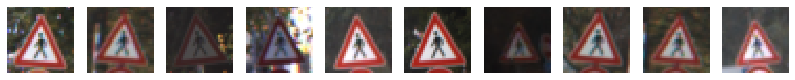

Children crossing


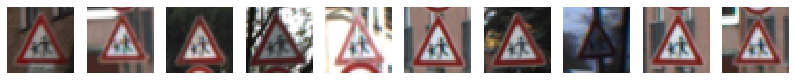

Bicycles crossing


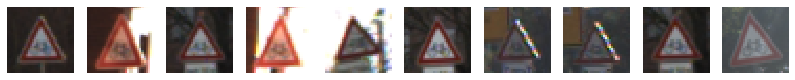

Beware of ice/snow


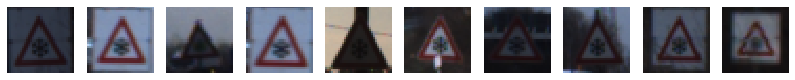

Wild animals crossing


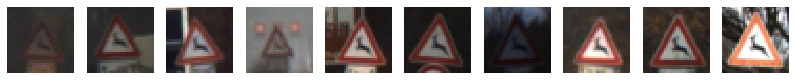

End of all speed and passing limits


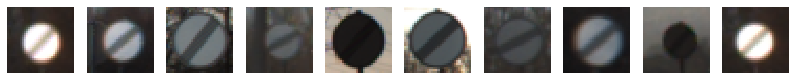

Turn right ahead


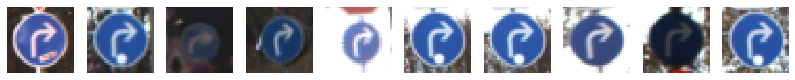

Turn left ahead


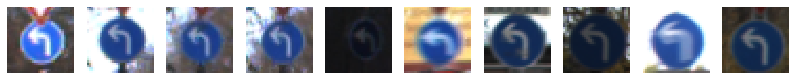

Ahead only


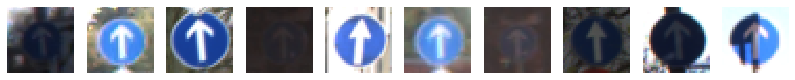

Go straight or right


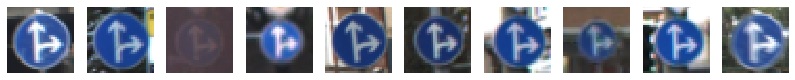

Go straight or left


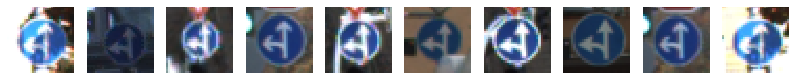

Keep right


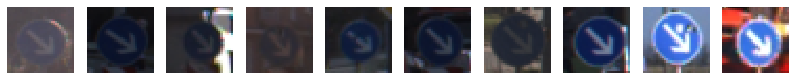

Keep left


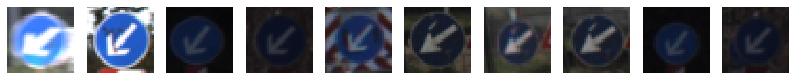

Roundabout mandatory


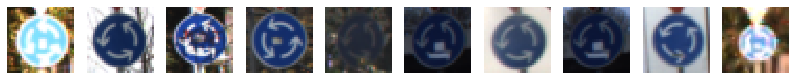

End of no passing


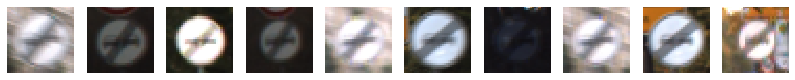

End of no passing by vehicles over 3.5 metric tons


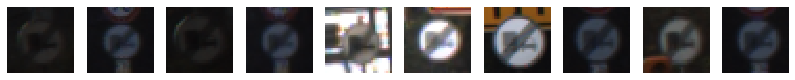

In [10]:
for i in range(n_classes):
    print(signs[i])
    fig = plt.figure(figsize=(14, 14))
    # Get 10 random indices from the selected class
    index = random.sample(list(np.where(y_train == i)[0]), 10)
    for j in range(10):
        axis = fig.add_subplot(1, 10, j+1, xticks=[], yticks=[])
        axis.imshow(X_train[index[j]])
    plt.show()

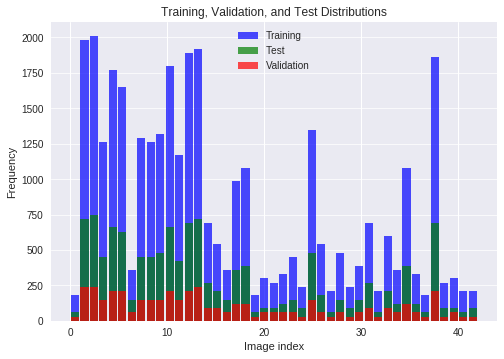

In [11]:
# Distribution of the data set 
n, bins, patches = plt.hist(y_train, bins=n_classes, color='blue',
                            alpha=0.7, rwidth=0.85, label='Training')
n, bins, patches = plt.hist(y_test, bins=n_classes,
                            alpha=0.7, rwidth=0.85, color='green', label='Test')
n, bins, patches = plt.hist(y_val, bins=n_classes,
                            alpha=0.7, rwidth=0.85, color='red', label='Validation')

plt.grid(axis='y', alpha=0.75)
plt.xlabel('Image index')
plt.ylabel('Frequency')
plt.title('Training, Validation, and Test Distributions')
plt.legend(loc='upper center')
plt.show()

We dont have enough samples for some of the images. The ones below 250 samples. This is an umbalanced dataset and hence, we might need to do data augmentation to get more data or use an under- or over-sampling strategy to balance. 

** Pre-processing **

For this specific problem grey images were shown to be as good as the RGB counterparts. Hence, we will convert the images to gray and apply a local histogram equalization to enhance the low contrast images. 

In [0]:
def local_histo_equalize(image):
    """
    Apply local histogram equalization to grayscale images.
        Parameters:
            image: A grayscale image.
    """
    kernel = morp.disk(30)
    img_local = rank.equalize(image, selem=kernel)
    return img_local
 

In [0]:
# Normalization 
def preprosses(image):
    """
    Normalizes the images to the range [0,1] 
    
    Args:
        image: a numpy array representing the image    

    Returns:
        image: normalized image
    """
    # RGB to gray
    image = color.rgb2gray(image)
    
    # Histogram equalization
    images = list(map(local_histo_equalize, image))
    image = np.reshape(image, (image.shape[0], image_size[0], image_size[1], 1))
    return image


In [66]:
X_train = preprosses(X_train)
X_test = preprosses(X_test)
X_val = preprosses(X_val)


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [23]:
# we will use functional programming with the map() function
#X_train = list(map(normalize, X_train))

X_train, y_train = shuffle(X_train, y_train)
X_train.shape


(34799, 32, 32, 1)

In [33]:
# Model Archtecture
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'valid', 
                 activation ='relu', input_shape = (32,32,1)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'valid', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'valid', 
                 activation ='relu'))
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'valid', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation = "softmax"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 28, 28, 64)        1664      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 24, 24, 64)        102464    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 10, 10, 128)       73856     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 8, 8, 128)         147584    
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 4, 4, 128)         0         
__________

In [0]:
# Compile the model
model.compile(optimizer = 'adam' , loss = "sparse_categorical_crossentropy", metrics=["accuracy"])

In [35]:
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data= (X_val, y_val))


Train on 34799 samples, validate on 4410 samples
Epoch 1/20
34799/34799 [==============================] - 12s 355us/step - loss: 2.1492 - acc: 0.4048 - val_loss: 0.5184 - val_acc: 0.8669
Epoch 2/20
34799/34799 [==============================] - 11s 322us/step - loss: 0.5434 - acc: 0.8336 - val_loss: 0.1896 - val_acc: 0.9440
Epoch 3/20
34799/34799 [==============================] - 11s 322us/step - loss: 0.2937 - acc: 0.9096 - val_loss: 0.1195 - val_acc: 0.9626
Epoch 4/20
34799/34799 [==============================] - 11s 319us/step - loss: 0.1889 - acc: 0.9421 - val_loss: 0.0880 - val_acc: 0.9753
Epoch 5/20
34799/34799 [==============================] - 11s 319us/step - loss: 0.1558 - acc: 0.9555 - val_loss: 0.0839 - val_acc: 0.9794
Epoch 6/20
34799/34799 [==============================] - 11s 319us/step - loss: 0.1305 - acc: 0.9613 - val_loss: 0.0586 - val_acc: 0.9839
Epoch 7/20
34799/34799 [==============================] - 11s 320us/step - loss: 0.1063 - acc: 0.9680 - val_loss: 0.0

[0.09517732719283556, 0.9794932699637666]

In [36]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print('Test accuracy:', test_accuracy)

12630/12630 [==============================] - 2s 171us/step
Test accuracy: 0.9794932699637666


A test accuracy of **97.9 %** is great! However, it can still be improved. To look into ways of improving the results, lets visualize the images our model failed to predict correctly. 

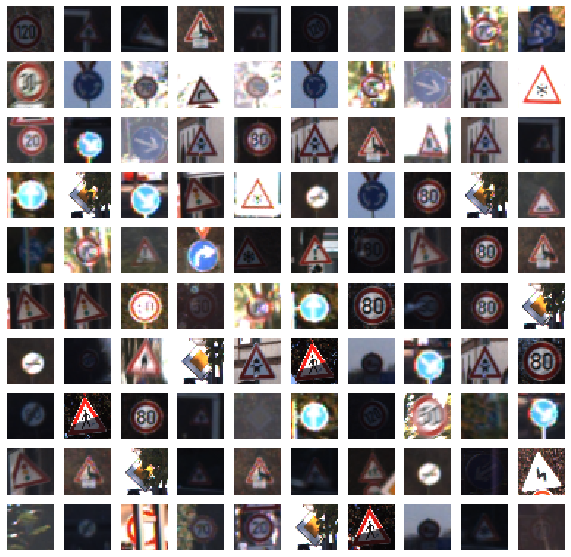

In [78]:
# Get the original test images 
X_test_orig, y_test = load_data(testing)

# Predictions
predictions = model.predict(X_test)

y_pred = np.argmax(predictions, axis=1)

# Get the indices of the wrong preditions
wrong_predictions = np.where(y_test != y_pred)[0]


fig = plt.figure(figsize=(10, 10))
for j in range(100):
    axis = fig.add_subplot(10, 10, j+1, xticks=[], yticks=[])
    axis.imshow(X_test_orig[wrong_predictions[j]])
plt.show()


**Some of the reasons as to why these images were classified incorrectly**

*   images too bright or too dark, i.e., sunlight artefacts. Better preprocessing needed to solve this issue
*   obstructed images
*   not well represented in the training set. Surely, data augmentation and would improve the results

**Data augmentation possibilites:**

Some of the images can be fliped to get more data. In some cases, the fliping would not change the class label. In this cases we would obtain twice as many samples. In others, fliping either horizontaly or vertically would result in another class (e.g., Keep right will be Keep left). 

We can apply some distortions (rotations, scaling, or translations) to the images we have

The results tend to be biased towards predicting the classes with more data. Hence, we can also perform sampling techniques, for example,  SMOTE, and ADASYN. 
